In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Packages installation (to be run every time)

In [ ]:
!pip install pyspark
!pip install h2o
!pip install TPOT
!pip install autokeras
!pip install autopytorch
!pip install autoPyTorch[forecasting]
!pip install auto-sklearn
!pip install google-cloud-automl
!pip install google-cloud-aiplatform

# Importing packages

In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error  
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from warnings import filterwarnings
filterwarnings('ignore')

## Importing Pyspark

In [5]:
# Importing pyspark libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.conf import SparkConf
from pyspark import SparkContext
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window
# Configuration of Spark Session
spark = SparkSession.builder.appName("wind_turbine_project").getOrCreate()
spark.version

'3.3.1'

In [6]:
directory_path = os.getcwd()

In [7]:
directory_path

'/content'

In [8]:
data_directory_path = os.getcwd()

data_path = os.path.join(data_directory_path, "wind_turbine_data.csv")
wind_pandas_df = pd.read_csv(data_path)
spark_df = spark.createDataFrame(wind_pandas_df)

In [9]:
wind_pandas_df

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [10]:
 print(spark_df.count())

50530


In [11]:
# Caching the dataset
spark_df.cache()
# Converting all the column names to lower case
spark_df = spark_df.toDF(*[c.lower() for c in spark_df.columns])
print('Show the first 5 rows')
print(spark_df.show(5))
print()
print('What are the variable data types?')
print(spark_df.printSchema())
print()
print('How many observations do we have?')
print(spark_df.count())

Show the first 5 rows
+----------------+-------------------+----------------+-----------------------------+------------------+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|
+----------------+-------------------+----------------+-----------------------------+------------------+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|
+----------------+-------------------+----------------+-----------------------------+------------------+
only showing top 5 rows

None

Wh

In [12]:

from pyspark.sql.functions import substring
spark_df = spark_df.withColumn("month", substring("date/time", 4,2))
spark_df = spark_df.withColumn("day", substring("date/time",1,2))
spark_df = spark_df.withColumn("hour", substring("date/time", 12,2))
spark_df = spark_df.withColumn("minute", substring("date/time", 15,2))


from pyspark.sql.types import IntegerType
spark_df = spark_df.withColumn('month', spark_df.month.cast(IntegerType()))
spark_df = spark_df.withColumn('day', spark_df.day.cast(IntegerType()))
spark_df = spark_df.withColumn('hour', spark_df.hour.cast(IntegerType()))
spark_df = spark_df.withColumn('minute', spark_df.minute.cast(IntegerType()))

print(spark_df.show(30))

+----------------+-------------------+----------------+-----------------------------+------------------+-----+---+----+------+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|month|day|hour|minute|
+----------------+-------------------+----------------+-----------------------------+------------------+-----+---+----+------+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|    1|  1|   0|     0|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|    1|  1|   0|    10|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|    1|  1|   0|    20|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|    1|  1|   0|    30|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|    1| 

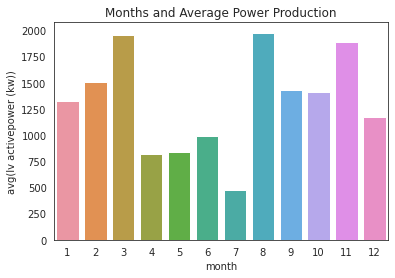

In [13]:
# Average power production by month
monthly = spark_df.groupby('month').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='month', y='avg(lv activepower (kw))', data=monthly)
plt.title('Months and Average Power Production');

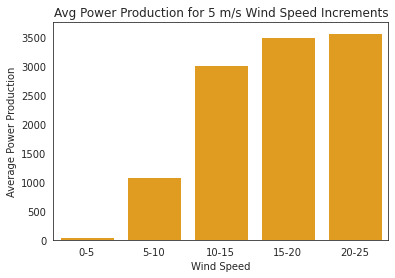

In [14]:
# Finding average power production for 5 m/s wind speed increments
wind_speed = []
avg_power = []
for i in [0,5,10,15,20]:
    avg_value = spark_df.filter((spark_df['wind speed (m/s)'] > i) 
                                & (spark_df['wind speed (m/s)'] <= i+5))\
                                .agg({'lv activepower (kw)':'mean'}).collect()[0][0] 
    avg_power.append(avg_value)
    wind_speed.append(str(i) + '-' + str(i+5))

sns.barplot(x=wind_speed, y=avg_power, color='orange')
plt.title('Avg Power Production for 5 m/s Wind Speed Increments')
plt.xlabel('Wind Speed')
plt.ylabel('Average Power Production');

,wind speed (m/s),theoretical_power_curve (kwh),lv activepower (kw)
2421,2.572229,0.0,0.0
439,2.322925,0.0,0.0
1696,0.697769,0.0,0.0
4972,2.039471,0.0,0.0
5371,1.768786,0.0,0.0


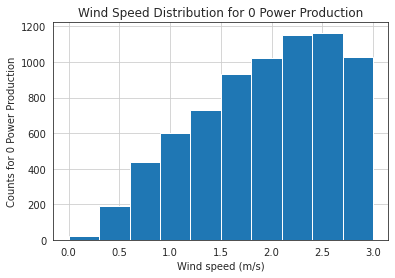

In [15]:
# Filter the big data where the real and theoritical power productions are equal to 0
zero_theo_power = spark_df.filter((spark_df['lv activepower (kw)'] == 0)
                                  & (spark_df['theoretical_power_curve (kwh)'] == 0)).toPandas()

display(zero_theo_power[['wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']].sample(5))

# Let's see the wind speed distribution for 0 power production
zero_theo_power['wind speed (m/s)'].hist()
plt.title('Wind Speed Distribution for 0 Power Production')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Counts for 0 Power Production');

In [16]:
# Observations for the wind speed > 3m/s and power production = 0, 
# While theoritically there should be power production
zero_power = spark_df.filter((spark_df['lv activepower (kw)'] == 0)
                            & (spark_df['theoretical_power_curve (kwh)'] != 0)
                            & (spark_df['wind speed (m/s)'] > 3)).toPandas()
display(zero_power.head())
print('No of Observations (while Wind Speed > 3 m/s and Power Production = 0): ', len(zero_power))

,date/time,lv activepower (kw),wind speed (m/s),theoretical_power_curve (kwh),wind direction (°),month,day,hour,minute
0,03 01 2018 15:40,0.0,3.743307,83.986265,245.068207,1,3,15,40
1,03 01 2018 16:40,0.0,3.034003,17.180593,221.086502,1,3,16,40
2,03 01 2018 16:50,0.0,3.197354,25.431221,232.679596,1,3,16,50
3,03 01 2018 17:00,0.0,3.907811,110.979604,241.973099,1,3,17,0
4,04 01 2018 13:50,0.0,3.441704,45.742725,79.094109,1,4,13,50


No of Observations (while Wind Speed > 3 m/s and Power Production = 0):  3497


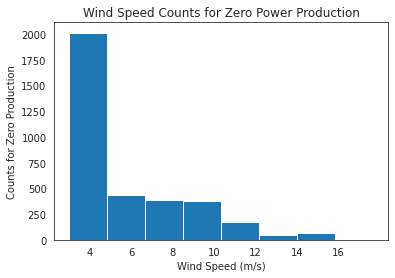

In [17]:
zero_power['wind speed (m/s)'].plot.hist(bins=8)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Counts for Zero Production')
plt.title('Wind Speed Counts for Zero Power Production')
plt.xticks(ticks=np.arange(4,18,2));

In [18]:
# Excluding the observations meeting the filter criterias 
spark_df = spark_df.filter(~((spark_df['lv activepower (kw)'] == 0)
                            & (spark_df['theoretical_power_curve (kwh)'] != 0)
                            & (spark_df['wind speed (m/s)'] > 3)))

In [19]:
# Create a pandas df for visualization
wind_speed = spark_df.select('wind speed (m/s)').toPandas()

# Defining the quantiles and interquantile range
Q1 = wind_speed['wind speed (m/s)'].quantile(0.25)
Q3 = wind_speed['wind speed (m/s)'].quantile(0.75)
IQR = Q3-Q1
# Defining the lower and upper threshold values
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

print('Quantile (0.25): ', Q1, '  Quantile (0.75): ', Q3)
print('Lower threshold: ', lower, ' Upper threshold: ', upper)

Quantile (0.25):  4.45584678649902   Quantile (0.75):  10.4771900177001
Lower threshold:  -4.576168060302599  Upper threshold:  19.50920486450172


In [20]:
# Fancy indexing for outliers
outlier_tf = (wind_speed['wind speed (m/s)'] < lower) | (wind_speed['wind speed (m/s)'] > upper)

print('Total Number of Outliers: ', len(wind_speed['wind speed (m/s)'][outlier_tf]))
print('--'*15)
print('Some Examples of Outliers:')
print(wind_speed['wind speed (m/s)'][outlier_tf].sample(10))

Total Number of Outliers:  407
------------------------------
Some Examples of Outliers:
3224     19.759100
3522     23.532080
7506     19.946011
42751    20.408600
8241     19.650930
8988     19.939600
46358    21.234489
3272     20.596560
8989     20.127670
6976     19.846300
Name: wind speed (m/s), dtype: float64


In [21]:
spark_df.select('wind speed (m/s)', 'lv activepower (kw)')\
.filter(spark_df['wind speed (m/s)'] >= 19)\
.agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      3566.4634427974706|
+------------------------+



In [22]:
from pyspark.sql import functions as F
spark_df = spark_df.withColumn('wind speed (m/s)', 
                               F.when(F.col('wind speed (m/s)') > 19.447, 19)
                               .otherwise(F.col('wind speed (m/s)')))
spark_df.count()

47033

In [23]:
# High level power production
spark_df.filter(((spark_df['month'] == 3) | (spark_df['month'] == 8) | (spark_df['month'] == 11)) 
                & ((spark_df['hour'] >= 16) | (spark_df['hour'] <= 24)) 
                & ((spark_df['wind direction (°)'] > 0) | (spark_df['wind direction (°)'] < 90))
                & ((spark_df['wind direction (°)'] > 180) | (spark_df['wind direction (°)'] < 225))
               ).agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      2013.4446757880403|
+------------------------+



In [24]:
# Low level power production
spark_df.filter((spark_df['month'] == 7) 
                & ((spark_df['hour'] >= 9) | (spark_df['hour'] <= 11)) 
                & ((spark_df['wind direction (°)'] > 90) | (spark_df['wind direction (°)'] < 160))
               ).agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|       503.1644205414878|
+------------------------+



## Preparing for ML

In [25]:
# Preparing the independent variables (Features)
from pyspark.ml.feature import VectorAssembler

# Converting lv activepower (kw) variable as label
spark_df = spark_df.withColumn('label', spark_df['lv activepower (kw)'])
spark_df = spark_df.drop('theoretical_power_curve (kwh)')

In [26]:
spark_timestamp_df = spark_df.withColumn("timestamp",to_timestamp(col("date/time"),"dd MM yyyy HH:mm")).drop("date/time", "lv activepower (kw)")
spark_timestamp_df.count()

47033

In [27]:
spark_timestamp_df.columns

['wind speed (m/s)',
 'wind direction (°)',
 'month',
 'day',
 'hour',
 'minute',
 'label',
 'timestamp']

In [28]:
df_pandas = spark_timestamp_df.toPandas()
rename_dictionary = {'wind speed (m/s)' : 'wind_speed', 'wind direction (°)' : 'wind_direction'}
df_pandas.rename(columns=rename_dictionary, inplace=True)

In [29]:
df_pandas.columns

Index(['wind_speed', 'wind_direction', 'month', 'day', 'hour', 'minute',
       'label', 'timestamp'],
      dtype='object')

## Standard Scaling

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns_to_scale = ["wind_speed","wind_direction","month","day","hour", "minute", "label"]
df_scaled = df_pandas.copy()
scaling_dict = {}
for col in columns_to_scale:
    df_scaled[col] = scaler.fit_transform(np.array(df_scaled[col]).reshape(-1,1))
    scaling_dict[col] = [scaler.mean_, np.sqrt(scaler.var_)]
df_scaled

,wind_speed,wind_direction,month,day,hour,minute,label,timestamp
0,-0.562532,1.469800,-1.669781,-1.682987,-1.665854,-1.462890,-0.782822,2018-01-01 00:00:00
1,-0.477149,1.563055,-1.669781,-1.682987,-1.665854,-0.877278,-0.726511,2018-01-01 00:10:00
2,-0.585082,1.605374,-1.669781,-1.682987,-1.665854,-0.291667,-0.839094,2018-01-01 00:20:00
3,-0.480105,1.591281,-1.669781,-1.682987,-1.665854,0.293945,-0.752575,2018-01-01 00:30:00
4,-0.499445,1.531056,-1.669781,-1.682987,-1.665854,0.879557,-0.782361,2018-01-01 00:40:00
...,...,...,...,...,...,...,...,...
47028,0.879179,-0.466141,1.625784,1.790039,1.643251,-0.877278,1.190860,2018-12-31 23:10:00
47029,-0.084230,-0.427745,1.625784,1.790039,1.643251,-0.291667,0.213444,2018-12-31 23:20:00
47030,0.176704,-0.420412,1.625784,1.790039,1.643251,0.293945,0.608155,2018-12-31 23:30:00
47031,0.410022,-0.425207,1.625784,1.790039,1.643251,0.879557,0.848446,2018-12-31 23:40:00


In [31]:
scaling_dict

{'wind_speed': [array([7.68860482]), array([4.22601644])],
 'wind_direction': [array([123.72129768]), array([92.71575796])],
 'month': [array([6.57342717]), array([3.33782008])],
 'day': [array([15.53764378]), array([8.63800029])],
 'hour': [array([11.57855123]), array([6.95051785])],
 'minute': [array([24.98054557]), array([17.07616514])],
 'label': [array([1404.91334361]), array([1309.19416897])]}

In [32]:
spark_timestamp_df.show()

+----------------+------------------+-----+---+----+------+----------------+-------------------+
|wind speed (m/s)|wind direction (°)|month|day|hour|minute|           label|          timestamp|
+----------------+------------------+-----+---+----+------+----------------+-------------------+
|5.31133604049682|  259.994903564453|    1|  1|   0|     0|380.047790527343|2018-01-01 00:00:00|
|5.67216682434082|   268.64111328125|    1|  1|   0|    10| 453.76919555664|2018-01-01 00:10:00|
|5.21603679656982|  272.564788818359|    1|  1|   0|    20|306.376586914062|2018-01-01 00:20:00|
|5.65967416763305|  271.258087158203|    1|  1|   0|    30|419.645904541015|2018-01-01 00:30:00|
|5.57794094085693|  265.674285888671|    1|  1|   0|    40|380.650695800781|2018-01-01 00:40:00|
|5.60405206680297|   264.57861328125|    1|  1|   0|    50|402.391998291015|2018-01-01 00:50:00|
|5.79300785064697|  266.163604736328|    1|  1|   1|     0|447.605712890625|2018-01-01 01:00:00|
|5.30604982376098|  257.949493

In [33]:
df_scaled.to_csv(os.path.join(data_directory_path, "scaled_wind_data.csv"), index=False) 

In [34]:
train_set, val_test_set= np.split(df_scaled, [int(.80 *len(df_scaled))])
val_set, test_set= np.split(val_test_set, [int(.50 *len(val_test_set))])

In [35]:
train_set

,wind_speed,wind_direction,month,day,hour,minute,label,timestamp
0,-0.562532,1.469800,-1.669781,-1.682987,-1.665854,-1.462890,-0.782822,2018-01-01 00:00:00
1,-0.477149,1.563055,-1.669781,-1.682987,-1.665854,-0.877278,-0.726511,2018-01-01 00:10:00
2,-0.585082,1.605374,-1.669781,-1.682987,-1.665854,-0.291667,-0.839094,2018-01-01 00:20:00
3,-0.480105,1.591281,-1.669781,-1.682987,-1.665854,0.293945,-0.752575,2018-01-01 00:30:00
4,-0.499445,1.531056,-1.669781,-1.682987,-1.665854,0.879557,-0.782361,2018-01-01 00:40:00
...,...,...,...,...,...,...,...,...
37621,-0.155767,-0.804103,1.026590,0.169293,0.636132,-0.291667,-0.283924,2018-10-17 16:20:00
37622,0.077114,-0.752170,1.026590,0.169293,0.636132,0.293945,0.041603,2018-10-17 16:30:00
37623,0.229435,-0.731486,1.026590,0.169293,0.636132,0.879557,0.239687,2018-10-17 16:40:00
37624,0.116955,-0.747658,1.026590,0.169293,0.636132,1.465168,0.099322,2018-10-17 16:50:00


In [36]:
train_df=spark.createDataFrame(train_set) 
valid_df=spark.createDataFrame(val_set) 
test_df=spark.createDataFrame(test_set) 

In [37]:
train_df.count()

37626

In [39]:
def prepare_spark_df(spark_df_input, features_to_transform):
  """
  :param spark_df_input: input spark df to be transformed with vector assembler
  :param features_to_transform: list of str representing the features to be used
  :return: the VectorAssembler transformed dataframe
  """
  vectorAssembler = VectorAssembler(inputCols = features_to_transform, outputCol = 'features')
  va_df = vectorAssembler.transform(spark_df_input)
  df_spark = va_df.select('features', 'label')
  return df_spark

features_to_transform = ['month', 'day', 'hour', 'minute', 'wind_speed', 'wind_direction']

train_spark = prepare_spark_df(train_df, features_to_transform)
valid_spark = prepare_spark_df(valid_df, features_to_transform)
test_spark = prepare_spark_df(test_df, features_to_transform)

print('Train dataset spark: ', train_spark.count())
print('Valid dataset spark: ', valid_spark.count())
print('Test dataset spark: ', test_spark.count())

Train dataset spark:  37626
Valid dataset spark:  4703
Test dataset spark:  4704


## Pyspark model GBTRegressor

In [224]:
from pyspark.ml.regression import GBTRegressor

# Instantiate the GBTRegressor model
gbt_instance = GBTRegressor(featuresCol='features', labelCol='label')

# Train the model
gbt_trained_model = gbt_instance.fit(train_spark)

# Prediction generation
gbt_prediction = gbt_trained_model.transform(test_spark)
gbt_prediction = np.array(gbt_prediction.select("prediction").rdd.flatMap(lambda x: x).collect())

In [225]:
gbt_prediction

array([0.53510427, 0.0523069 , 0.49926295, ..., 0.04421316, 0.45796743,
       0.70655806])

## H2O

In [42]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpyxcp0kkc
  JVM stdout: /tmp/tmpyxcp0kkc/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpyxcp0kkc/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_unknownUser_0nfanv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [43]:
wind_train = h2o.H2OFrame(train_set)
wind_valid = h2o.H2OFrame(val_set)
wind_test = h2o.H2OFrame(test_set)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [44]:
h2o_model = H2OAutoML(max_models = 10, seed = 10, verbosity="info")

In [45]:
y = 'label'
x = wind_train.columns

In [46]:
h2o_model.train(x = x, y = y, training_frame = wind_train, validation_frame = wind_valid)

AutoML progress: |
20:03:47.362: Project: AutoML_1_20221222_200347
20:03:47.364: 5-fold cross-validation will be used.
20:03:47.364: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
20:03:47.365: Setting stopping tolerance adaptively based on the training frame: 0.005155324113429332
20:03:47.365: Build control seed: 10
20:03:47.366: training frame: Frame key: AutoML_1_20221222_200347_training_Key_Frame__upload_be2507612eacacf51427026c5ad948bd.hex    cols: 8    rows: 37626  chunks: 2    size: 1507256  checksum: -3036031163718723218
20:03:47.366: validation frame: Frame key: Key_Frame__upload_85e9fd79ce7d62c67c3479c4af1548b3.hex    cols: 8    rows: 4703  chunks: 1    size: 160974  checksum: 6176963358277050271
20:03:47.366: leaderboard frame: NULL
20:03:47.367: blending frame: NULL


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,0.0341239,0.0006737,0.0335212,0.0349274,0.0346760,0.0340780,0.0334169
mean_residual_deviance,0.0068191,0.0008504,0.0061611,0.0082905,0.0067699,0.0064204,0.0064539
mse,0.0068191,0.0008504,0.0061611,0.0082905,0.0067699,0.0064204,0.0064539
null_deviance,7448.5293,129.93013,7496.927,7366.5723,7654.5513,7338.304,7386.292
r2,0.9931081,0.0008746,0.9938090,0.9915847,0.9932623,0.9934319,0.993453
residual_deviance,51.3032,6.2551928,46.411507,61.98792,51.56606,48.19818,48.35233
rmse,0.0824575,0.0049887,0.0784926,0.0910521,0.0822792,0.0801276,0.0803359
rmsle,nan,0.0,nan,nan,nan,nan,nan


In [47]:
leaderboard = h2o_model.leaderboard
leaderboard.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20221222_200347,0.0826322,0.00682808,0.0340299,nan,0.00682808
StackedEnsemble_BestOfFamily_1_AutoML_1_20221222_200347,0.083406,0.00695656,0.0343961,nan,0.00695656
GBM_4_AutoML_1_20221222_200347,0.0863843,0.00746225,0.0380605,nan,0.00746225
GBM_3_AutoML_1_20221222_200347,0.087084,0.00758363,0.0370834,nan,0.00758363
GBM_2_AutoML_1_20221222_200347,0.0871224,0.00759032,0.0386764,nan,0.00759032
XGBoost_3_AutoML_1_20221222_200347,0.088692,0.00786628,0.0411517,nan,0.00786628
GBM_1_AutoML_1_20221222_200347,0.0899852,0.00809733,0.0419409,nan,0.00809733
XRT_1_AutoML_1_20221222_200347,0.0959624,0.00920879,0.0515959,nan,0.00920879
XGBoost_2_AutoML_1_20221222_200347,0.102869,0.0105821,0.0557381,nan,0.0105821
XGBoost_1_AutoML_1_20221222_200347,0.114581,0.0131288,0.0653276,nan,0.0131288


In [189]:
h2o_prediction=h2o_model.leader.predict(wind_test)
h2o_prediction = h2o_prediction.as_data_frame().values

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


## PERFORMANCE H2O

In [48]:
h2o_model.leader.model_performance(wind_test)

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.11839827131290544
RMSE: 0.34409049872512526
MAE: 0.18387022729068275
RMSLE: NaN
Mean Residual Deviance: 0.11839827131290544

## Graphic Performance comparison

In [52]:
#Preparing X data
data_x_train = train_set.drop(columns=["timestamp"]).astype("float64").drop(columns=["label"])
data_x_val = val_set.drop(columns=["timestamp"]).astype("float64").drop(columns=["label"])
data_x_test = test_set.drop(columns=["timestamp"]).astype("float64").drop(columns=["label"])

#Preparing Y data
data_y_train = train_set["label"].astype("float64")
data_y_val = val_set["label"].astype("float64")
data_y_test = test_set["label"].astype("float64")

print(data_y_train.shape) 
print(data_y_val.shape) 
print(data_y_test.shape)

(37626,)
(4703,)
(4704,)


## TPOT

In [53]:
from tpot import TPOTRegressor

In [54]:
tpot = TPOTRegressor(generations=4, population_size=20, verbosity=2)
tpot.fit(data_x_train, data_y_train)

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.03654206441472134

Generation 2 - Current best internal CV score: -0.03434143994834635

Generation 3 - Current best internal CV score: -0.03357553440994136

Generation 4 - Current best internal CV score: -0.03073638407555756

Best pipeline: KNeighborsRegressor(SelectPercentile(input_matrix, percentile=20), n_neighbors=42, p=1, weights=uniform)


TPOTRegressor(generations=4, population_size=20, verbosity=2)

In [99]:
tpot_prediction = tpot.predict(data_x_test)

In [55]:
print('MSE:')
print(mean_squared_error(data_y_test, tpot.predict(data_x_test)))
print('RMSE:')
print(np.sqrt(mean_squared_error(data_y_test, tpot.predict(data_x_test))))

MSE:
0.09983864302723613
RMSE:
0.3159725352419671


## Auto Keras

In [56]:
import autokeras as ak

In [57]:
predict_from = 1
lookback = 5
clf = ak.TimeseriesForecaster(
    lookback = lookback,
    predict_from=predict_from,
    max_trials=1,
    objective="val_loss",
)
# Train the TimeSeriesForecaster with train data
clf.fit(
    x=data_x_train,
    y=data_y_train,
    validation_data=(data_x_val, data_y_val),
    batch_size=32,
    epochs=10,
)
# Predict with the best model(includes original training data).


Trial 1 Complete [00h 03m 52s]
val_loss: 0.03656015917658806

Best val_loss So Far: 0.03656015917658806
Total elapsed time: 00h 03m 52s
Epoch 1/10
1176/1176 [==============================] - 24s 14ms/step - loss: 0.5548 - mean_squared_error: 0.5548 - val_loss: 0.2347 - val_mean_squared_error: 0.2347
Epoch 2/10
1176/1176 [==============================] - 14s 12ms/step - loss: 0.0966 - mean_squared_error: 0.0966 - val_loss: 0.1871 - val_mean_squared_error: 0.1871
Epoch 3/10
1176/1176 [==============================] - 14s 12ms/step - loss: 0.0708 - mean_squared_error: 0.0708 - val_loss: 0.1334 - val_mean_squared_error: 0.1334
Epoch 4/10
1176/1176 [==============================] - 16s 13ms/step - loss: 0.0610 - mean_squared_error: 0.0610 - val_loss: 0.0940 - val_mean_squared_error: 0.0940
Epoch 5/10
1176/1176 [==============================] - 15s 13ms/step - loss: 0.0535 - mean_squared_error: 0.0535 - val_loss: 0.0613 - val_mean_squared_error: 0.0613
Epoch 6/10
1176/1176 [============

In [58]:
predictions = clf.predict(pd.concat([data_x_train,data_x_test]))

1323/1323 [==============================] - 12s 9ms/step


In [106]:
last_values = [predictions[-1], predictions[-1], predictions[-1], predictions[-1], predictions[-1]]

autokeras_prediction = np.append(predictions, last_values)

In [60]:
len(autokeras_predictions)

4704

In [61]:
autokeras_prediction

array([0.39807144, 0.45212534, 0.88232446, ..., 0.7007666 , 0.7007666 ,
       0.7007666 ], dtype=float32)

## XGBOOST

In [278]:
random_search.best_params_

{'num_parallel_tree': 3, 'min_child_weight': 1, 'max_depth': 6, 'gamma': 5}

In [73]:
# Train the model
xgb_model.fit(data_x_train, data_y_train, early_stopping_rounds=10, eval_set=[(data_x_val, data_y_val)], verbose=1)

# Prediction generation
xgboost_prediction = xgb_model.predict(data_x_test)

[21:41:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.878752
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.792453
[2]	validation_0-rmse:0.714758
[3]	validation_0-rmse:0.644888
[4]	validation_0-rmse:0.582092
[5]	validation_0-rmse:0.525828
[6]	validation_0-rmse:0.475244
[7]	validation_0-rmse:0.430077
[8]	validation_0-rmse:0.389565
[9]	validation_0-rmse:0.353554
[10]	validation_0-rmse:0.321273
[11]	validation_0-rmse:0.292249
[12]	validation_0-rmse:0.266904
[13]	validation_0-rmse:0.244471
[14]	validation_0-rmse:0.224561
[15]	validation_0-rmse:0.206775
[16]	validation_0-rmse:0.191707
[17]	validation_0-rmse:0.177479
[18]	validation_0-rmse:0.166171
[19]	validation_0-rmse:0.156853
[20]	validation_0-rmse:0.147705
[21]	validation_0-rmse:0.140355
[22]	validation_0-rmse:0.133991
[23]	validation_0-rmse:0.129842
[24]	validation_0-rmse:0.125724
[25]	validation_0-

In [83]:
xgb_model = xgboost.XGBRegressor(num_parallel_tree=3)

# Train the model
xgb_model.fit(data_x_train, data_y_train, early_stopping_rounds=15, eval_set=[(data_x_val, data_y_val)], verbose=1)
print(xgb_model)
# Prediction generation
xgboost_prediction = xgb_model.predict(data_x_test)

[21:49:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.878752
Will train until validation_0-rmse hasn't improved in 15 rounds.
[1]	validation_0-rmse:0.792453
[2]	validation_0-rmse:0.714758
[3]	validation_0-rmse:0.644888
[4]	validation_0-rmse:0.582092
[5]	validation_0-rmse:0.525828
[6]	validation_0-rmse:0.475244
[7]	validation_0-rmse:0.430077
[8]	validation_0-rmse:0.389565
[9]	validation_0-rmse:0.353554
[10]	validation_0-rmse:0.321273
[11]	validation_0-rmse:0.292249
[12]	validation_0-rmse:0.266904
[13]	validation_0-rmse:0.244471
[14]	validation_0-rmse:0.224561
[15]	validation_0-rmse:0.206775
[16]	validation_0-rmse:0.191707
[17]	validation_0-rmse:0.177479
[18]	validation_0-rmse:0.166171
[19]	validation_0-rmse:0.156853
[20]	validation_0-rmse:0.147705
[21]	validation_0-rmse:0.140355
[22]	validation_0-rmse:0.133991
[23]	validation_0-rmse:0.129842
[24]	validation_0-rmse:0.125724
[25]	validation_0-

In [84]:
xgb_model.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 1,
 'verbosity': 1,
 'num_parallel_tree': 3}

In [85]:
xgboost_prediction

array([0.63296056, 0.05044121, 0.5529051 , ..., 0.10924616, 0.5278293 ,
       0.71537256], dtype=float32)

In [86]:
len(xgboost_prediction)

4704

## Auto Sklearn

In [90]:
import autosklearn.regression

In [91]:
automl_sklearn = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder="/tmp/autosklearn_regression_example_tmp",
)
automl_sklearn.fit(data_x_train, data_y_train, dataset_name="wind_power")

[WARNING] [2022-12-22 21:51:21,087:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-22 21:51:24,212:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-22 21:51:27,895:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-22 21:51:31,398:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-22 21:51:33,996:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-22 21:51:35,013:Client-EnsembleBuilder] No runs were available to build an ensemble from


AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                     per_run_time_limit=30, time_left_for_this_task=120,
                     tmp_folder='/tmp/autosklearn_regression_example_tmp')

In [92]:
autosklearn_prediction = automl_sklearn.predict(data_x_test)

In [71]:
print('MSE:')
print(mean_squared_error(data_y_test, autosklearn_prediction))
print('RMSE:')
print(np.sqrt(mean_squared_error(data_y_test, autosklearn_prediction)))

MSE:
0.2069235341441477
RMSE:
0.4548884853941103



## Auto Pytorch Code generico

In [114]:
import os
import tempfile as tmp
import warnings
import copy

os.environ['JOBLIB_TEMP_FOLDER'] = tmp.gettempdir()
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sktime.datasets import load_longley
targets, features = load_longley()

forecasting_horizon = 3

# Dataset optimized by APT-TS can be a list of np.ndarray/ pd.DataFrame where each series represents an element in the
# list, or a single pd.DataFrame that records the series
# index information: to which series the timestep belongs? This id can be stored as the DataFrame's index or a separate
# column
# Within each series, we take the last forecasting_horizon as test targets. The items before that as training targets
# Normally the value to be forecasted should follow the training sets
y_train = [targets[: -forecasting_horizon]]
y_test = [targets[-forecasting_horizon:]]

# same for features. For uni-variant models, X_train, X_test can be omitted and set as None
X_train = [features[: -forecasting_horizon]]
# Here x_test indicates the 'known future features': they are the features known previously, features that are unknown
# could be replaced with NAN or zeros (which will not be used by our networks). If no feature is known beforehand,
# we could also omit X_test
known_future_features = list(features.columns)
X_test = [features[-forecasting_horizon:]]

start_times = [targets.index.to_timestamp()[0]]
freq = '1Y'

from autoPyTorch.api.time_series_forecasting import TimeSeriesForecastingTask

In [118]:
api = TimeSeriesForecastingTask()

api.search(
    X_train=X_train,
    y_train=copy.deepcopy(y_train),
    X_test=X_test,
    optimize_metric='mean_MSE_forecasting',
    n_prediction_steps=forecasting_horizon,
    memory_limit=16 * 1024,   # Currently, forecasting models use much more memories
    freq=freq,
    start_times=start_times,
    func_eval_time_limit_secs=50,
    total_walltime_limit=60,
    min_num_test_instances=1000,  # proxy validation sets. This only works for the tasks with more than 1000 series
    known_future_features=known_future_features,
)


test_sets = []

# We could construct test sets from scratch
for feature, future_feature, target, start_time in zip(X_train, X_test,y_train, start_times):
    test_sets.append(
        TimeSeriesSequence(X=feature.values,
                           Y=target.values,
                           X_test=future_feature.values,
                           start_time=start_time,
                           is_test_set=True,
                           # additional information required to construct a new time series sequence
                           **api.dataset.sequences_builder_kwargs
                           )
    )
# Alternatively, if we only want to forecast the value after the X_train, we could directly ask datamanager to
# generate a test set:
# test_sets2 = api.dataset.generate_test_seqs()

pred = api.predict(test_sets)

[WARNING] [2022-12-22 10:24:12,661:Client-AutoPyTorch:c62ec23e-81e2-11ed-8067-0242ac1c000c:1] Capping the func_eval_time_limit_secs to 29 to have time for a least 2 models to ensemble.
[WARNING] [2022-12-22 10:24:32,457:Client-EnsembleBuilder] No models better than random - using Dummy Score!Number of models besides current dummy model: 1. Number of dummy models: 1
[WARNING] [2022-12-22 10:25:05,345:Client-EnsembleBuilder] No models better than random - using Dummy Score!Number of models besides current dummy model: 1. Number of dummy models: 1


In [119]:
pred

array([[68655., 68655., 68655.]])

## Auto Pytorch

In [164]:
from autoPyTorch.api.time_series_forecasting import TimeSeriesForecastingTask
import copy
from autoPyTorch.datasets.time_series_dataset import TimeSeriesSequence

In [165]:
forecasting_horizon = data_x_test.shape[0]
known_future_features = list(data_x_test.columns)
start_times = [pd.to_datetime(wind_pandas_df["Date/Time"][0])]
freq = '10min'
X_train = [data_x_train]
y_train = [data_y_train]

api = TimeSeriesForecastingTask()

api.search(
    X_train=X_train,
    y_train=copy.deepcopy(y_train),
    freq = freq,
    optimize_metric='mean_MSE_forecasting',
    start_times = start_times,
    n_prediction_steps=forecasting_horizon,
    known_future_features=known_future_features,
)

[WARNING] [2022-12-22 11:29:21,949:Client-AutoPyTorch:e046fac6-81eb-11ed-8067-0242ac1c000c:1] Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (98.000000)
[WARNING] [2022-12-22 11:29:21,951:Client-AutoPyTorch:e046fac6-81eb-11ed-8067-0242ac1c000c:1] Capping the func_eval_time_limit_secs to 49 to have time for a least 2 models to ensemble.


In [177]:
X_train = [data_x_train]
y_train = [data_y_train]
X_test = [data_x_test]
start_times = [pd.to_datetime(list(test_set["timestamp"]))[0]]
test_sets = []

# We could construct test sets from scratch
for feature, future_feature, target, start_time in zip(X_train, X_test,y_train, start_times):
    test_sets.append(
        TimeSeriesSequence(X=feature.values,
                           Y=target.values,
                           X_test=future_feature.values,
                           start_time=start_time,
                           is_test_set=True,
                           # additional information required to construct a new time series sequence
                           **api.dataset.sequences_builder_kwargs
                           )
    )

TypeError: ignored

In [200]:
test_sequence = TimeSeriesSequence(X=data_x_test,Y=data_y_test, is_test_set=True, start_time= start_times[0])

In [198]:
pred = api.predict(test_sequence)

TypeError: ignored

In [186]:
pred = api.predict([data_x_test])

AssertionError: ignored

In [168]:
auto_pytorch_prediction = pred[0]

In [169]:
auto_pytorch_prediction

array([-0.34542701, -0.34542701, -0.34542701, ..., -0.34542701,
       -0.34542701, -0.34542701])

In [170]:
len(auto_pytorch_prediction)

4704

## Google Cloud AutoML

In [93]:
data_x_test.to_csv(os.path.join(data_directory_path, "data_wind_test.csv"), index=False) 

In [94]:
from google.cloud import storage
SERVICE_ACCOUNT_PATH = os.path.join(data_directory_path, "seismic-trail-358809-c1ba94c43f31.json")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = SERVICE_ACCOUNT_PATH
BUCKET_NAME = "cloud-ai-platform-d23f5ea6-9144-43b9-b051-ad0cae6ea809"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = SERVICE_ACCOUNT_PATH
client = storage.Client()
for blob in client.list_blobs(BUCKET_NAME):
  if "prediction.results" in str(blob):
      blob.download_to_filename(os.path.join(data_directory_path,"prediction_gcp", str(blob)[-37:-19]))

In [95]:
prediction = pd.DataFrame()
for file_name in os.listdir("prediction_gcp"):
  prediction = pd.concat([prediction, pd.read_csv(os.path.join(data_directory_path,"prediction_gcp",file_name))])

In [163]:
gcp_prediction = prediction

In [164]:
gcp_prediction = gcp_prediction.sort_values(by=['month','day','hour','minute'])

In [165]:
gcp_prediction = gcp_prediction['predicted_label'].values


## Final performance comparison

In [226]:
data_x_test_results = data_x_test.copy()
data_x_test_results['autosklearn_prediction'] = autosklearn_prediction
data_x_test_results['TPOT_prediction'] = tpot_prediction
data_x_test_results['H2O_prediction'] = h2o_prediction
data_x_test_results['GBT_regressor_prediction'] = gbt_prediction
data_x_test_results['AutoKeras_prediction'] = autokeras_prediction
data_x_test_results['XGBoost'] = xgboost_prediction
data_x_test_results['GCP_AutoML'] = gcp_prediction
data_x_test_results['Target'] = data_y_test
data_x_test_results = data_x_test_results.sort_values(by=['month','day','hour','minute'])

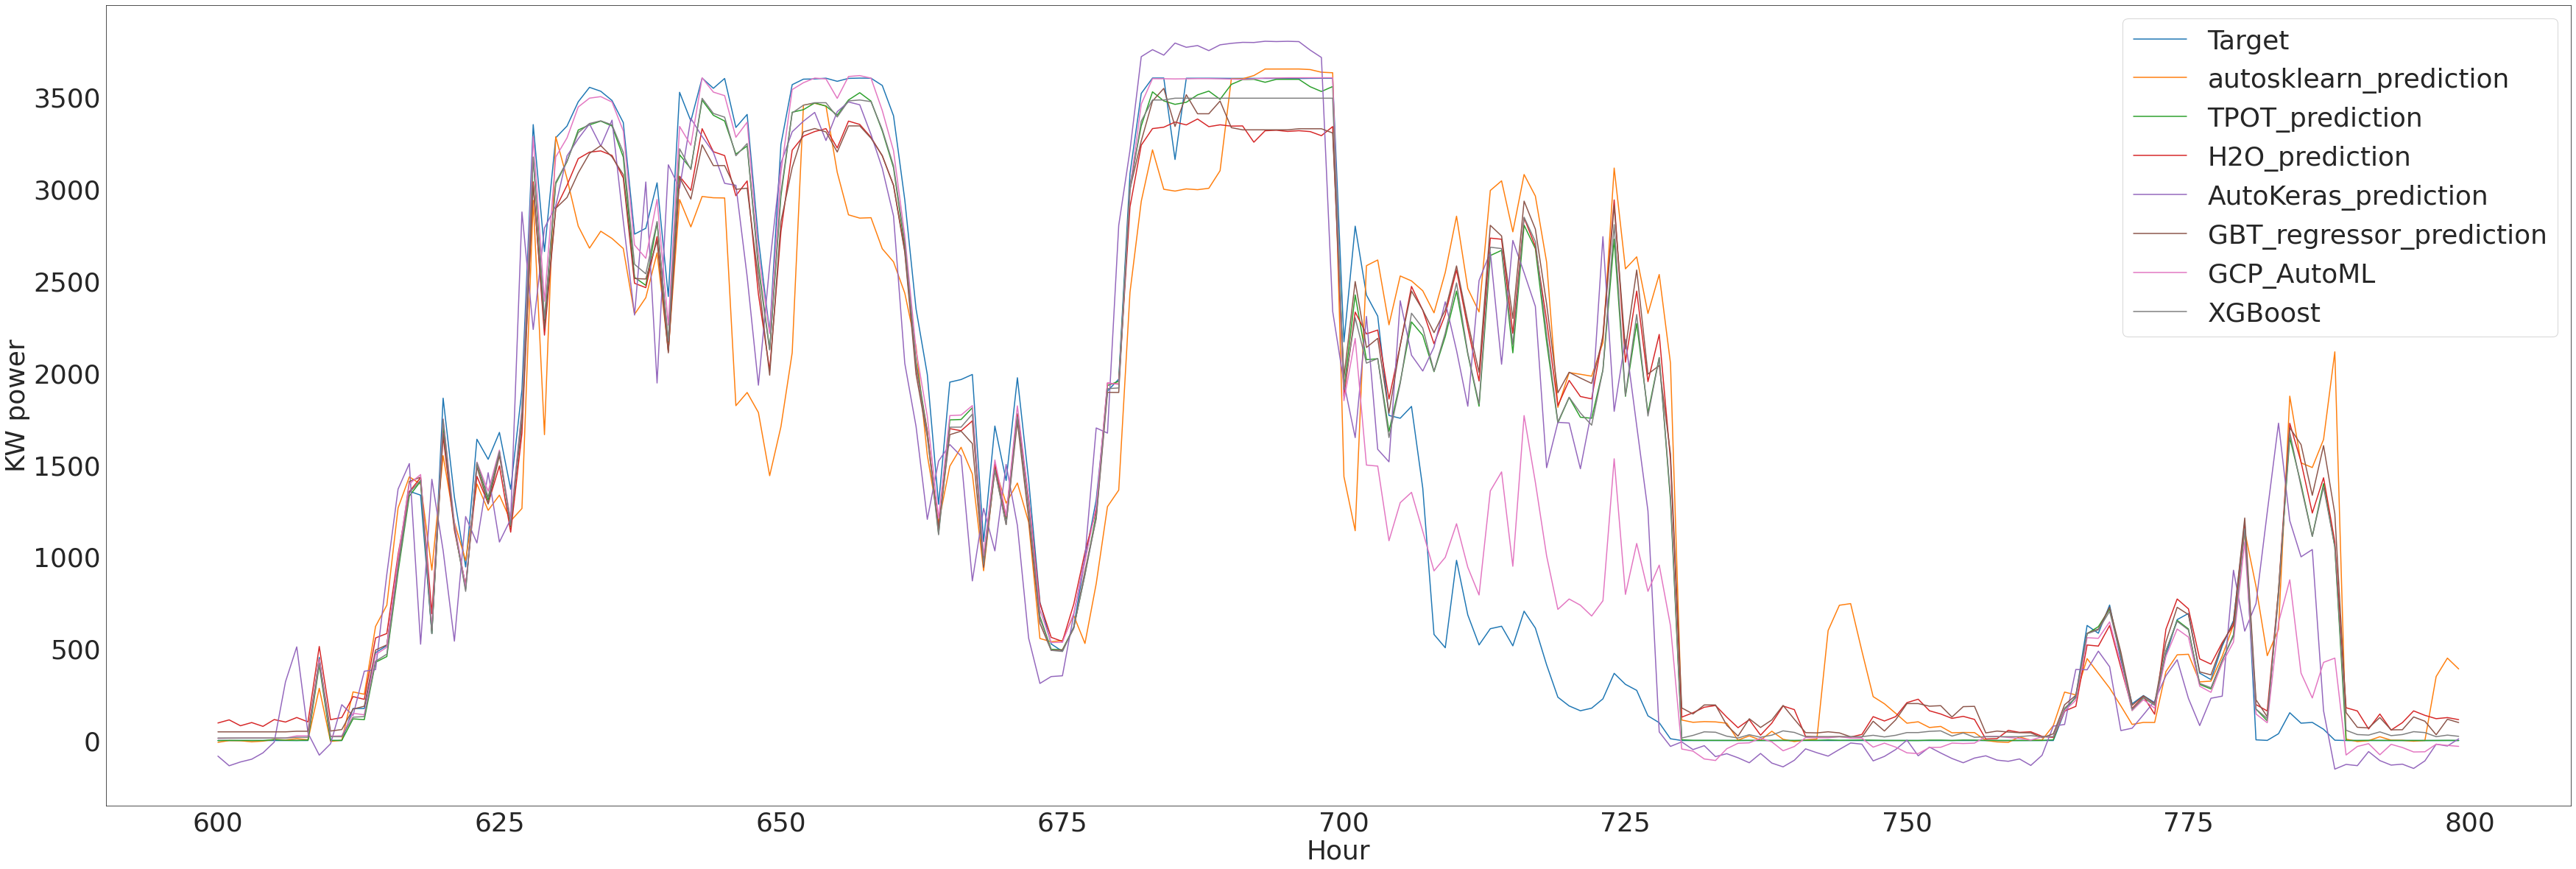

In [235]:
import matplotlib.pyplot as plt

def plot_power_comparison(data, cols_to_plot, cols_to_group, min_granularity, starting_point, ending_point):
  """
  Constructs the comparison plot, grouping according to cols_to_group and min granularity. 
  Also possible to select only smaller part of the complete sequence, for a more clear comparison
  :param data: dataframe containing the test features, predictions, and target variables
  :param columns_to_plot: list of str representing the columns to plot
  :param cols_to_group: list of str to perform grouping on
  :param min_granularity: minimum granularity of aggregation and X-Axis label
  :param starting_point: first point to plot of the sequence
  :param ending_point: last point to plot of the sequence

  :return:
  """
  SMALL_SIZE = 8
  MEDIUM_SIZE = 10
  BIGGER_SIZE = 36

  plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
  plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
  plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
  plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
  plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
  plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
  plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

  data_grouped = data.groupby(cols_to_group).mean().reset_index()

  fig = plt.figure()
  fig.set_figwidth(60)
  fig.set_figheight(20)


  for col in cols_to_plot:
    plt.plot(y=data_grouped[col][starting_point:ending_point], x=x_values, label=col)
    plt.ylabel('KW power')
    plt.xlabel(min_granularity)
    plt.legend()
  plt.show()
  
# Rescale the data by
# multiplying each prediction and target column for standard dev
# and subtracting the mean
prediction_col_to_rescale = ['Target','autosklearn_prediction', 'TPOT_prediction', 'H2O_prediction', 'GBT_regressor_prediction', 'AutoKeras_prediction', 'GCP_AutoML', 'XGBoost']
data_x_test_results_rescaled = data_x_test_results.copy()
for pred_col in prediction_col_to_rescale:
  data_x_test_results_rescaled[pred_col] = scaling_dict['label'][1]*data_x_test_results_rescaled[pred_col] + scaling_dict['label'][0]

cols_to_plot = ['Target','autosklearn_prediction', 'TPOT_prediction', 'H2O_prediction', 'AutoKeras_prediction','GBT_regressor_prediction', 'GCP_AutoML', 'XGBoost']

cols_to_group = ["month","day","hour"]
min_granularity = "Hour"
starting_point = 600
ending_point = 800
plot_power_comparison(data_x_test_results_rescaled, cols_to_plot, cols_to_group, min_granularity, starting_point, ending_point)

## Numerical RMSE scaled and real KW values comparison

In [232]:
def get_evaluation_dictionary(data, y_target, cols_to_evaluate):
  """
  Construct the evaluation dictionary based on RMSE
  :param data: dataframe containing the test features, predictions, and target variables
  :param y_target: actual target column
  :param cols_to_evaluate: columns list to be evaluated
  :return: the evaluation dictionary
  """
  evaluation_rmse_dict = {}
  for col in cols_to_evaluate:
    evaluation_rmse_dict[col] = np.sqrt(mean_squared_error(y_target, data[col]))
  return evaluation_rmse_dict

cols_to_evaluate = ['autosklearn_prediction', 'TPOT_prediction', 'H2O_prediction', 'GBT_regressor_prediction', 'AutoKeras_prediction', 'GCP_AutoML', 'XGBoost']
dict_standard_scaled_errors = get_evaluation_dictionary(data_x_test_results, data_y_test, cols_to_evaluate)
dict_rescaled_errors = get_evaluation_dictionary(data_x_test_results_rescaled, scaling_dict['label'][1]*data_y_test + scaling_dict['label'][0], cols_to_evaluate)

In [233]:
dict_standard_scaled_errors

{'autosklearn_prediction': 0.44585094725291824,
 'TPOT_prediction': 0.3159725352419671,
 'H2O_prediction': 0.3505004936793365,
 'GBT_regressor_prediction': 0.34577258056414106,
 'AutoKeras_prediction': 0.45068932923109556,
 'GCP_AutoML': 0.17393845027423427,
 'XGBoost': 0.3206811969398178}

In [234]:
dict_rescaled_errors

{'autosklearn_prediction': 583.705460374385,
 'TPOT_prediction': 413.66940069424027,
 'H2O_prediction': 458.873202546969,
 'GBT_regressor_prediction': 452.68344626514653,
 'AutoKeras_prediction': 590.0398418474765,
 'GCP_AutoML': 227.71920485914015,
 'XGBoost': 419.8339531327305}

## Re get results

In [101]:
data_x_test_results = pd.read_csv(os.path.join(data_directory_path, "prediction_results.csv"))

In [100]:
data_x_test_results.to_csv(os.path.join(data_directory_path, "prediction_results.csv"), index=False) 

In [102]:
np.sqrt(mean_squared_error(data_y_test, autokeras_predictions))

0.4403148227944832

In [237]:
data_y_test

42329    1.003296
42330    0.360583
42331    0.853681
42332    0.441770
42333    0.495421
           ...   
47028    1.190860
47029    0.213444
47030    0.608155
47031    0.848446
47032    1.081240
Name: label, Length: 4704, dtype: float64